In [35]:
# import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer 
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn import hmm
from matplotlib import cm
import os 
import warnings
import joblib
warnings.filterwarnings('ignore')

In [36]:
# Avoid data leakage to test data
# Impute missing data in train and test datasets using KNNImputer.
def impute_data(train, test):
    imputer = KNNImputer(n_neighbors=5)

    # Fit the imputer on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train_imputed = imputer.transform(train)
    test_imputed = imputer.transform(test)

    return train_imputed, test_imputed

In [37]:
def load_feature_indexToLog_data(start_date, test_start_dates, end_date, rebal_period):
    # Load index data, impute missing values and return train and test datasets
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data', 'Price Level')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        # Optional
#         'OptionMetrics - SPX Interpolated Premium for the Option (CALL)': 'OptionMetrics - SPX Interpolated Premium for the Option (CALL).xlsx',
#         'OptionMetrics - SPX Interpolated Premium for the Option (PUT)': 'OptionMetrics - SPX Interpolated Premium for the Option (PUT).xlsx',
    }
    
    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
            # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index)
            input = input.sort_index(ascending=False)

            # Calculate monthly log return to enhance the stationarity of the data
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            # use log return 
            index_df = np.log(reb_index / reb_index.shift(1)).dropna()

             # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]

            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]

            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan
            
            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue
    
    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [38]:
# There are two versions of the "load_feature" function: 
# one for data calculated based on the rate of change and another for data based solely on price levels. 
# However, for the purposes of this project, I convert all the data to be based on the log base.
def load_feature_pctTolog_data(start_date, test_start_dates, end_date, rebal_period):
    # Load index data, impute missing values and return train and test datasets
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data', 'RateOfChange')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends': 'CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends.xlsx',
        'CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends': 'CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends.xlsx',
        'US Rate of Change in Consumer Price Index': 'US Rate of Change in Consumer Price Index.xlsx',
        # Optional:
#        'CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends': 'CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends.xlsx',
#         'CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends': 'CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends.xlsx',
#         'CRSP Index File on the S&P 500 - Return on the S&P 500 Index': 'CRSP Index File on the S&P 500 - Return on the S&P 500 Index.xlsx',
#        'US 90 Day Bill Returns': 'US 90 Day Bill Returns.xlsx',
#       'US 30 Day Bill Returns': 'US 30 Day Bill Returns.xlsx',
#       'US 20 Year Bond Returns': 'US 20 Year Bond Returns.xlsx',
    }
    
    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
             # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index)
            input = input.sort_index(ascending=False)
            
             # Calculate monthly log return to enhance the stationarity of the data
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            # use log return 
            index_df = np.log(reb_index + 1 ).dropna()
             
            # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]
            
            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]
            
            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan

            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue
    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [39]:
# get target index data
def log_index_data_loading(start_date, test_start_dates, end_date, rebal_period):
    index_data_dir = os.path.join(os.getcwd(), 'data', 'index_data')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'CRSP Index File on the S&P 500 - Level of the S&P 500 Index':'CRSP Index File on the S&P 500 - Level of the S&P 500 Index.xlsx'
    }

    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
            # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index)
            input = input.sort_index(ascending=False)
            
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            
            # Method 1: based on percentage change            
            # Calculate monthly percentage changes to enhance the stationarity of the data
            # Fill the first with 0
            # index_df = input.iloc[:, 0].resample(rebal_period).first().pct_change().fillna(0)
            
            # Method 2: use log return (Better for HMM model)
            index_df = np.log(reb_index / reb_index.shift(1)).dropna()
            # use cumulative return 
            #  index_df = (reb_index/reb_index.iloc[0])      
            
             # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]
            
            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]

            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan

            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue

    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [40]:
# Define general parameters
train_start_date = '1/1/2000'
test_start_date = '1/1/2017'
test_end_date = '31/12/2022'
rebal_period = '1M'
train_df1, test_df1 = load_feature_indexToLog_data(train_start_date, test_start_date, test_end_date, rebal_period)
train_df2, test_df2 = load_feature_pctTolog_data(train_start_date, test_start_date, test_end_date, rebal_period)

In [41]:
# concat two training dataframe calucated by two different function
train_df = pd.concat([train_df1, train_df2], axis=1)
train_df.head()

,CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends,CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends,US Rate of Change in Consumer Price Index
2000-01-31,-0.021134,-0.021155,0.002967
2000-02-29,0.006335,0.006335,0.005907
2000-03-31,0.006967,0.006668,0.008211
2000-04-30,0.006566,0.006532,0.000584
2000-05-31,0.012716,0.012702,0.001167


In [42]:
# concat two testing dataframe calucated by two different function
test_df = pd.concat([test_df1, test_df2], axis=1)
test_df.head()

,CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends,CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends,US Rate of Change in Consumer Price Index
2017-01-31,0.008842,0.008834,0.005811
2017-02-28,-0.002391,-0.002498,0.003141
2017-03-31,0.012279,0.012074,0.000813
2017-04-30,-0.004072,-0.004140,0.002962
2017-05-31,-0.000577,-0.000584,0.000855


In [43]:
index_train_data, index_test_data = log_index_data_loading(train_start_date, test_start_date, test_end_date, rebal_period)



In [44]:
index_train_data.head()

,CRSP Index File on the S&P 500 - Level of the S&P 500 Index
2000-01-31,0.040315
2000-02-29,-0.032078
2000-03-31,-0.021583
2000-04-30,0.087941
2000-05-31,-0.025366


In [45]:
index_test_data.head()

,CRSP Index File on the S&P 500 - Level of the S&P 500 Index
2017-01-31,0.030010
2017-02-28,0.009574
2017-03-31,0.049806
2017-04-30,-0.015614
2017-05-31,0.012424


In [46]:
# function for plotting the index graph based on log return
def plot_target_index(index_train_data):
    ax = index_train_data.plot()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(float(x))))
    plt.xlabel('Date')
    plt.ylabel('Log return on S&P')
    plt.title('Log return on S&P')
    plt.show()

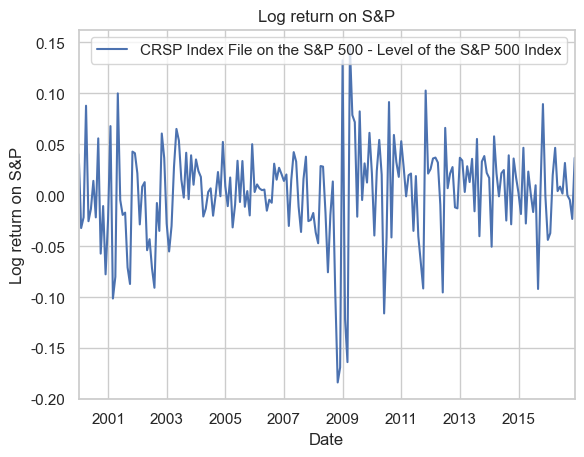

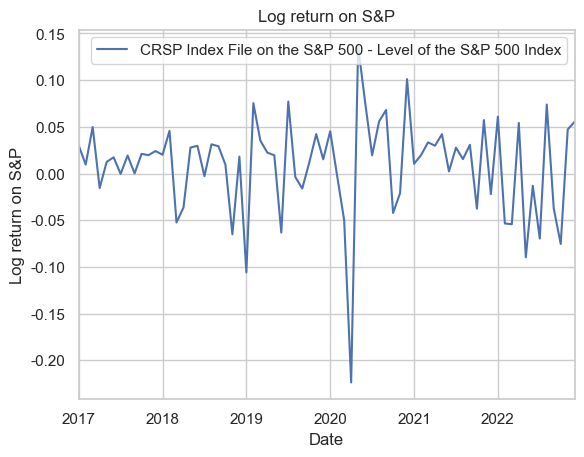

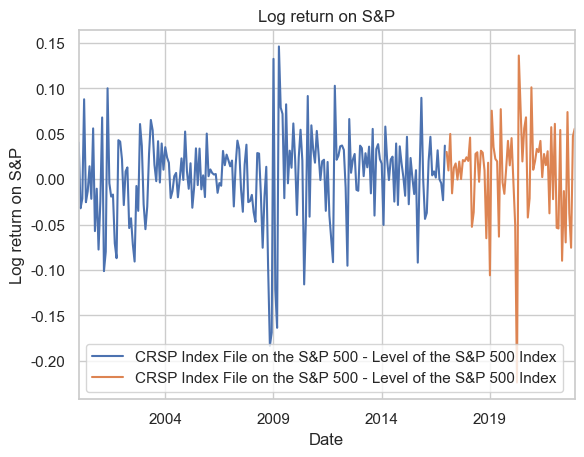

In [47]:
# Plot three graph (train, test, train+test index) in the same cell
# Call the function with train and test data separately
plot_target_index(index_train_data)
plot_target_index(index_test_data)

# Concatenate train and test data and then plot
combined_data = pd.concat([index_train_data, index_test_data], axis=1)
plot_target_index(combined_data)

# Show the plots
plt.show()

In [48]:
# Get EMA data for the feature/labels 
def EMA_dataFrame(index_train_data, index_test_data, spans):
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    for span in spans:
        try:
            train_EMA_column = index_train_data['CRSP Index File on the S&P 500 - Level of the S&P 500 Index'].ewm(span=span, adjust=False).mean()
            test_EMA_column = index_test_data['CRSP Index File on the S&P 500 - Level of the S&P 500 Index'].ewm(span=span, adjust=False).mean()

            # Handle Infinite values
            train_EMA_column.replace([np.inf, -np.inf], np.nan, inplace=True)
            test_EMA_column.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            train_imputed, test_imputed = impute_data(train_EMA_column.values.reshape(-1, 1), test_EMA_column.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=index_train_data.index, name=f'EMA {span}')
            test_imputed_series = pd.Series(test_imputed.flatten(), index=index_test_data.index, name=f'EMA {span}')
            
            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)

        except Exception as e:
            print(f"Error processing EMA span: {span}")
            print(str(e))
            continue

    return result_train_df, result_test_df


In [49]:
spans = [10, 50, 200] 
# Optional spans = [5, 10, 20, 50, 200]
train_EMA, test_EMA = EMA_dataFrame(index_train_data, index_test_data, spans)

In [50]:
train_EMA.head()

,EMA 10,EMA 50,EMA 200
2000-01-31 00:00:00,0.040315,0.040315,0.040315
2000-02-29 00:00:00,0.027152,0.037476,0.039594
2000-03-31 00:00:00,0.018292,0.035160,0.038986
2000-04-30 00:00:00,0.030955,0.037230,0.039473
2000-05-31 00:00:00,0.020715,0.034775,0.038828


In [51]:
test_EMA.head()

,EMA 10,EMA 50,EMA 200
2017-01-31 00:00:00,0.030010,0.030010,0.030010
2017-02-28 00:00:00,0.026294,0.029208,0.029806
2017-03-31 00:00:00,0.030569,0.030016,0.030005
2017-04-30 00:00:00,0.022172,0.028227,0.029551
2017-05-31 00:00:00,0.020400,0.027607,0.029381


In [52]:
# concat all the feature data into a large dataframe
train_df = pd.concat([train_df, train_EMA, index_train_data], axis=1)
test_df = pd.concat([test_df, test_EMA, index_test_data], axis=1)

In [53]:
train_df.head()

,CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends,CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends,US Rate of Change in Consumer Price Index,EMA 10,EMA 50,EMA 200,CRSP Index File on the S&P 500 - Level of the S&P 500 Index
2000-01-31 00:00:00,-0.021134,-0.021155,0.002967,0.040315,0.040315,0.040315,0.040315
2000-02-29 00:00:00,0.006335,0.006335,0.005907,0.027152,0.037476,0.039594,-0.032078
2000-03-31 00:00:00,0.006967,0.006668,0.008211,0.018292,0.035160,0.038986,-0.021583
2000-04-30 00:00:00,0.006566,0.006532,0.000584,0.030955,0.037230,0.039473,0.087941
2000-05-31 00:00:00,0.012716,0.012702,0.001167,0.020715,0.034775,0.038828,-0.025366


In [54]:
# code modify from https://github.com/mkhamisnab/Market_regime_classification_for_swing_trading

# Define the model
n_components = 3
n_iter = 10000
model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)

# Fit the model
model.fit(train_df)
hidden_states = model.predict(train_df)

print("Means and vars of each hidden state")
for num in range(model.n_components):
    print(f"{num}th hidden state")
    print(f"mean = {model.means_[num]}")
    print(f"var = {np.diag(model.covars_[num])}")

Means and vars of each hidden state
0th hidden state
mean = [ 0.00247738  0.00242561  0.00195914 -0.00530721  0.0127885   0.02644533
 -0.01148087]
var = [0.00045698 0.00045666 0.00024803 0.00052324 0.00041605 0.00033719
 0.00375736]
1th hidden state
mean = [0.00218424 0.00214051 0.00174787 0.00943306 0.00565731 0.01419098
 0.00919974]
var = [1.93041190e-04 1.92985808e-04 8.23463621e-05 1.19800160e-04
 8.29711249e-05 9.54378339e-05 1.14597272e-03]
2th hidden state
mean = [-0.00766673 -0.00770843  0.00143751 -0.02972906 -0.00599817  0.01977184
 -0.02012557]
var = [0.00191679 0.00191756 0.00060808 0.0010426  0.0006443  0.00064272
 0.00847   ]


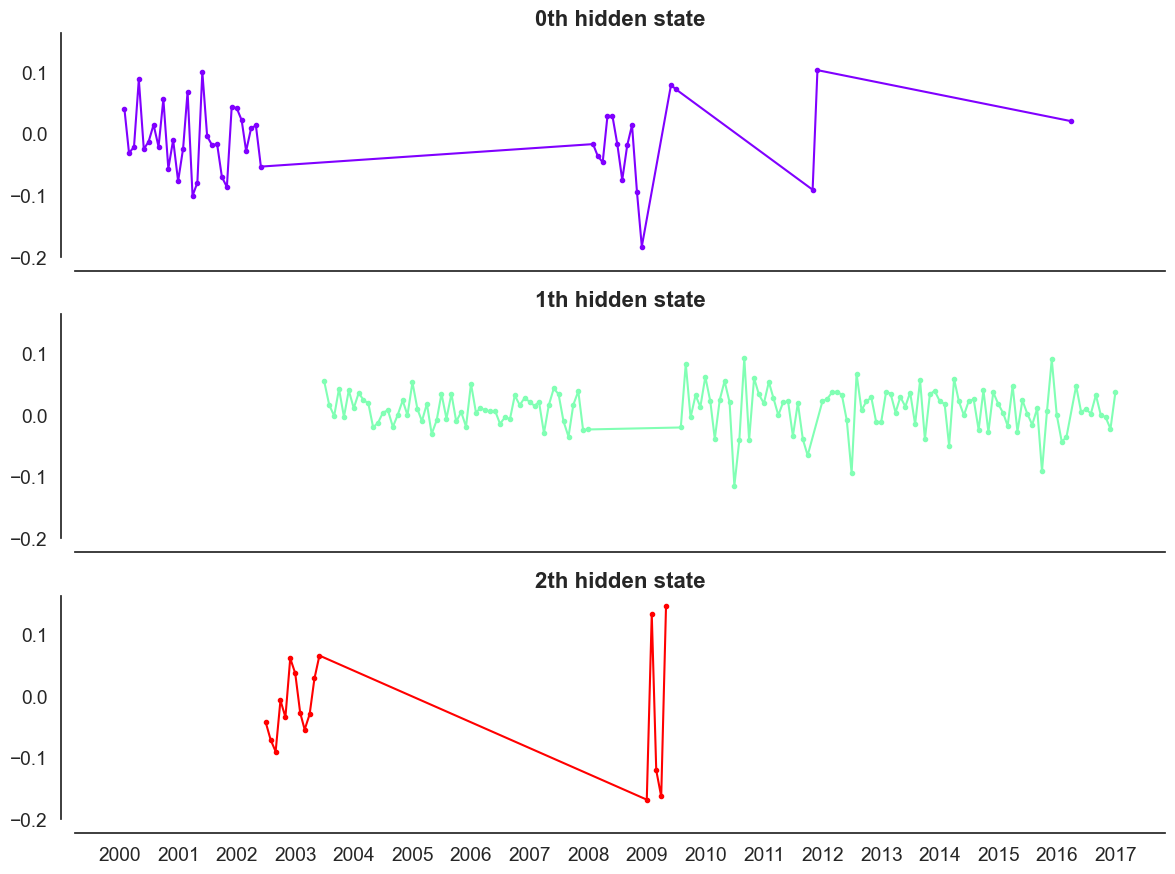

In [55]:
#The hidden states masking the adjusted closing prices are plotted
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3, 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(train_df.index.values[mask],
                 train_df['CRSP Index File on the S&P 500 - Level of the S&P 500 Index'].values[mask],
                 ".-", c=color)
    ax.set_title(f"{i}th hidden state", fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov Model_Regime Subplots.png')

In [56]:
 print("Model Score:", model.score(train_df))

Model Score: 5772.419621268722


In [57]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=train_df.index)
          .join(train_df, how='inner')
          .assign(SPX=train_df['CRSP Index File on the S&P 500 - Level of the S&P 500 Index'].cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))

In [58]:
states.head()

,Date,states,CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends,CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends,US Rate of Change in Consumer Price Index,EMA 10,EMA 50,EMA 200,CRSP Index File on the S&P 500 - Level of the S&P 500 Index,SPX
0,2000-01-31,0,-0.021134,-0.021155,0.002967,0.040315,0.040315,0.040315,0.040315,0.040315
1,2000-02-29,0,0.006335,0.006335,0.005907,0.027152,0.037476,0.039594,-0.032078,0.008237
2,2000-03-31,0,0.006967,0.006668,0.008211,0.018292,0.035160,0.038986,-0.021583,-0.013346
3,2000-04-30,0,0.006566,0.006532,0.000584,0.030955,0.037230,0.039473,0.087941,0.074595
4,2000-05-31,0,0.012716,0.012702,0.001167,0.020715,0.034775,0.038828,-0.025366,0.049229


In [59]:
def plot_train_market_regmie(states):
    # Set a custom color palette
    custom_palette = sns.color_palette("Set1", n_colors=3)
    sns.set(style="whitegrid")
    order = [0, 1, 2]
    fg = sns.FacetGrid(data=states, hue='states', hue_order=order,palette=custom_palette, aspect=1.31)
    # Map scatter plot onto the grid
    fg.map(plt.scatter, 'Date', "SPX", alpha=0.8)
    # Add legend
    fg.add_legend()
    # Add a title
    fg.fig.suptitle('Historical S&P 500 Regimes from 2000 to 2017', fontsize=20, fontweight='bold')
    # Adjust the figure size
    fg.fig.set_size_inches(10, 6)  
    # Remove spines
    sns.despine(offset=10)
    # Save the figure
    fg.savefig('train_df_on_S&P_500_Regimes.png', dpi=300)
    # Show the plot
    plt.show()


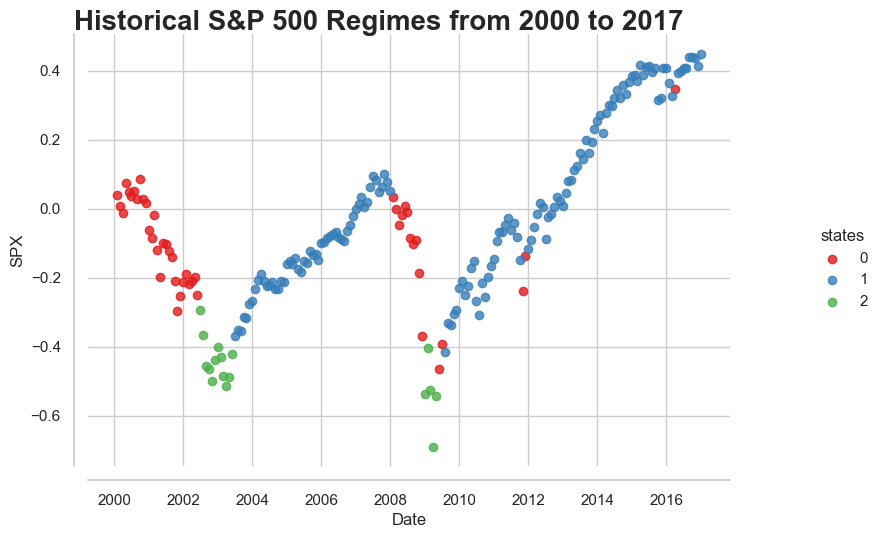

In [60]:
plot_train_market_regmie(states)

In [61]:
def save_modelToJoblib(model):
    if not os.path.exists('predict_market_regime_shift_by_HMM_model.joblib'):
        joblib.dump(model, 'predict_market_regime_shift_by_HMM_model.joblib')
    else:
        model = joblib.load('predict_market_regime_shift_by_HMM_model.joblib')

In [62]:
save_modelToJoblib(model)